## Importación de Librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de Datos

Vamos a tratar las columnas de fechas como tipo de dato `datetime`

In [3]:
df = pd.read_csv('../data/raw/autorenew.csv', parse_dates=['dateCrawled', 'dateCreated','lastSeen'])

## Análisis preliminar

In [4]:
df.head()

,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,NaN,1993,manually,0.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,coupe,2011,manually,187.0,NaN,125000,5,diesel,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,suv,2004,automatic,161.0,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,small car,2001,manually,74.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,small car,2008,manually,68.0,fabia,90000,7,diesel,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  datetime64[ns]
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   vehicleType          237765 non-null  object        
 6   yearOfRegistration   371528 non-null  int64         
 7   gearbox              351319 non-null  object        
 8   powerCV              371528 non-null  float64       
 9   model                351044 non-null  object        
 10  kilometer            371528 non-null  int64         
 11  monthOfRegistration  371528 non-null  int64         
 12  fuelType             338142 non-null  object        
 13  brand         

### Análisis de fechas

Comprobar los valores únicos de los años para el intervalo de tiempo

In [6]:
columnas_fechas = ['dateCrawled', 'dateCreated','lastSeen']

for col in columnas_fechas:
    print(f"Valores únicos de los años para {col}: {df[col].dt.year.unique()}")

Valores únicos de los años para dateCrawled: [2016]
Valores únicos de los años para dateCreated: [2016 2015 2014]
Valores únicos de los años para lastSeen: [2016]


Vemos que los datos se extrajeron exclusivamente en 2016, mientras que los anuncios únicamente de entre 2014 y 2016. Por lo tanto, asumiremos que los vehículos más nuevos solo pueden ser de 2016, en lugar del año actual. Mas allá de eso, estas columnas no aportan valor adicional, así que las eliminaremos.

In [7]:
df = df.drop(columns=columnas_fechas)

## Duplicados

Ahora que hemos eliminado las fechas, comprobaremos los duplicados. Es posible que un mismo vehículo haya sidoo registrado múltiples veces en diferentes fechas.

In [8]:
df.duplicated().sum()

np.int64(6624)

Efectivamente hay duplicados. Vamos a eliminarlos.

In [9]:
df = df.drop_duplicates()

## Valores nulos

Comprobar el total de valores nulos que tenemos.

In [10]:
nulos_porcentaje = df.isnull().mean().mul(100).round(2)

nulos_porcentaje[nulos_porcentaje > 0]

vehicleType          36.03
gearbox               5.43
model                 5.56
fuelType              9.07
notRepairedDamage    19.40
dtype: float64

## Variables numéricas

In [11]:
df.describe(include='number').T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,364904.0,17502.27,3620372.48,0.0,1150.0,2950.0,7150.0,2.147484e+09
yearOfRegistration,364904.0,2004.58,93.55,1000.0,1999.0,2003.0,2008.0,9.999000e+03
powerCV,364904.0,113.93,190.97,0.0,69.0,104.0,148.0,1.972600e+04
kilometer,364904.0,125685.07,40090.32,5000.0,125000.0,150000.0,150000.0,1.500000e+05
monthOfRegistration,364904.0,5.73,3.71,0.0,3.0,6.0,9.0,1.200000e+01
nrOfPictures,364904.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000e+00
postalCode,364904.0,50944.55,25775.64,1067.0,30655.0,49688.0,71642.0,9.999800e+04


### Observaciones rápidas:
- **price**: El precio mínimo es 0, lo cual es extraño, ya que un coche gratis no tiene sentido. Además, la media es mucho mayor que la mediana, lo que podría indicar la presencia de numerosos valores atípicos, posiblemente vehículos de lujo. Sin embargo, el precio máximo alzanza. un orden de magnitud de 1e9 (mil millones), loo cual es claramente imposible y probablemente se deba a errores.
- **yearOfRegistration**: El valor mínimo es 1000, lo cual es ilógico, ya que los coches no existían antes de 1900 (y los vehículos tan antiguos rara vez se venden). Además, hay valores como 9999, que probablemente sean errores de introducción de datos.
- **powerCV**: Un valor mínimo dde 0 es poco probable, y un máximo de 19.700CV es irreal, dado que incluso los coches de carreras más potentes rara vez superan los 1000CV. El resto de valores parecen razonables, con la maypría situándose en el rangoo típico ode entre 50 y 150CV.
- **kilometer**: Estos valores parecen razonables. Además, la media y la mediana son similares, lo que sugiere una distribución mas uniforme.
- **monthOfRegistration**: Esta variable es verdaderamente categórica. El valor mínimo, 0, es imposible, pero los valores entre 1 y 12 son lógicos y coherentes.
- **nrOfPictures**: Todas las entradas tienen un valor de 0. La eliminamos.
- **postalCode**: Esta variable corresponde a códigos postales y podría tratarse como categórica. Sin embargo, no hay información sobre el país al que pertenecen ni una forma de determinarlo, lo que limita su utilidad para el análisis. Por el nombre de algunas entradas, sospechamos que podría ser Alemania, pero no hay forma de confirmarlo. Por ello, decidimos eliminarla.

In [12]:
df = df.drop(columns=['nrOfPictures', 'postalCode'])

In [13]:
columnas_num = df.select_dtypes(include='number').columns

### Histogramas

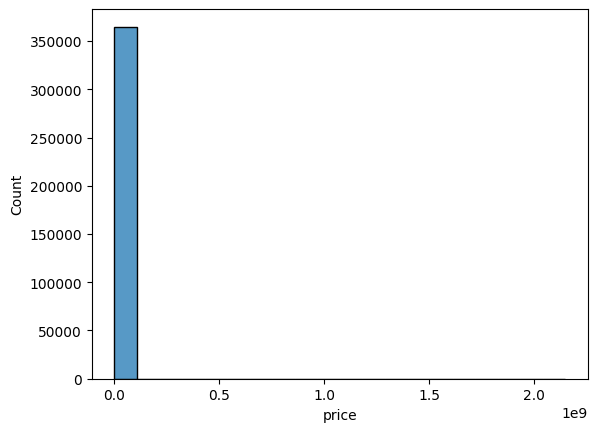

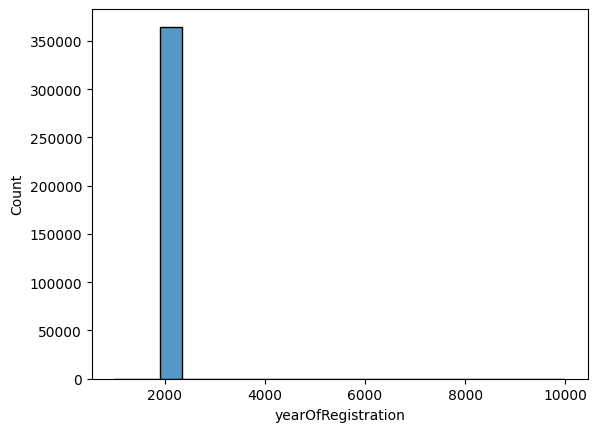

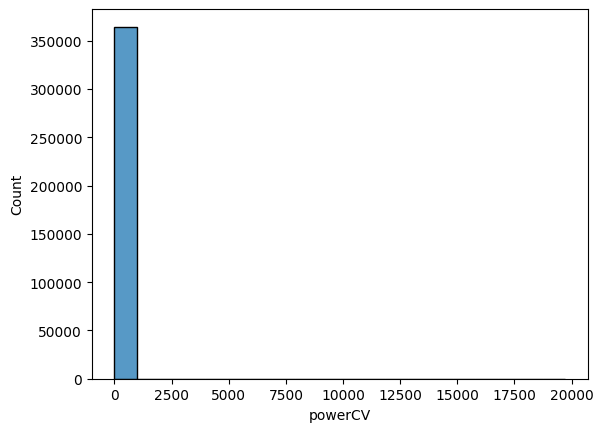

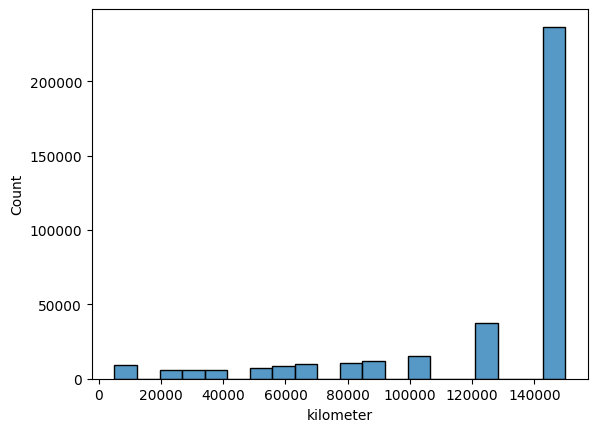

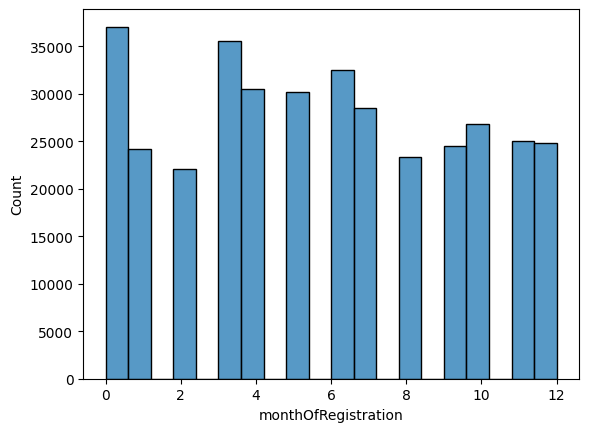

In [14]:
for col in columnas_num:

    plt.figure()
    sns.histplot(df[col], bins=20)
    plt.show()


### Boxplot

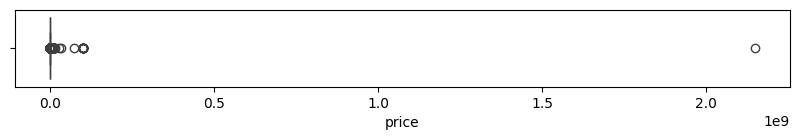

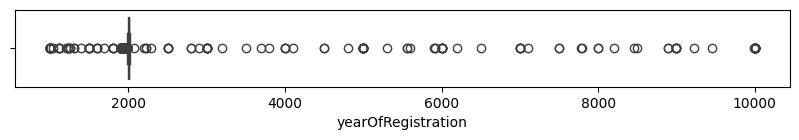

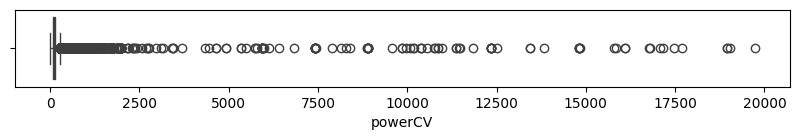

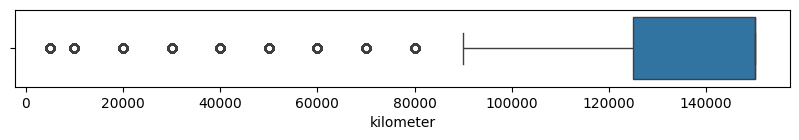

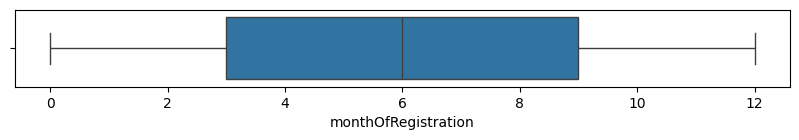

In [15]:
for col in columnas_num:

    plt.figure(figsize=(10,1))
    sns.boxplot(x=df[col])
    plt.show()


## Columnas Categóricas

In [16]:
df.describe(include=['O','category']).T

,count,unique,top,freq
name,364904,233531,Ford_Fiesta,650
seller,364904,2,private,364901
offerType,364904,2,offer,364892
vehicleType,233442,7,small car,78621
gearbox,345098,2,manually,269737
model,344610,251,golf,29539
fuelType,331820,7,petrol,220299
brand,364904,40,volkswagen,78227
notRepairedDamage,294128,2,no,258291


In [17]:
columnas_cat = df.select_dtypes(include=['O', 'category']).columns
columnas_cat

Index(['name', 'seller', 'offerType', 'vehicleType', 'gearbox', 'model',
       'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

In [18]:
for col in columnas_cat:

    print(f"La columna {col.upper()} tiene un total de {df[col].nunique()} valores distintos:\n")

    print(f"Los 10 valores más repetidos son")
    display(df[col].value_counts(dropna=False).head(10))

La columna NAME tiene un total de 233531 valores distintos:

Los 10 valores más repetidos son


name
Ford_Fiesta            650
BMW_318i               623
Opel_Corsa             614
Volkswagen_Golf_1.4    598
BMW_316i               515
BMW_320i               490
Volkswagen_Polo        471
Renault_Twingo         444
Volkswagen_Golf        427
Volkswagen_Golf_1.6    411
Name: count, dtype: int64

La columna SELLER tiene un total de 2 valores distintos:

Los 10 valores más repetidos son


seller
private       364901
commercial         3
Name: count, dtype: int64

La columna OFFERTYPE tiene un total de 2 valores distintos:

Los 10 valores más repetidos son


offerType
offer      364892
request        12
Name: count, dtype: int64

La columna VEHICLETYPE tiene un total de 7 valores distintos:

Los 10 valores más repetidos son


vehicleType
NaN            131462
small car       78621
combi           66264
bus             29640
convertible     22592
coupe           18757
suv             14249
other            3319
Name: count, dtype: int64

La columna GEARBOX tiene un total de 2 valores distintos:

Los 10 valores más repetidos son


gearbox
manually     269737
automatic     75361
NaN           19806
Name: count, dtype: int64

La columna MODEL tiene un total de 251 valores distintos:

Los 10 valores más repetidos son


model
golf        29539
andere      26078
NaN         20294
3er         20286
polo        12930
corsa       12360
astra       10595
passat      10077
a4          10026
c_klasse     8605
Name: count, dtype: int64

La columna FUELTYPE tiene un total de 7 valores distintos:

Los 10 valores más repetidos son


fuelType
petrol     220299
diesel     105088
NaN         33084
lpg          5287
cng           561
hybrid        275
other         207
electro       103
Name: count, dtype: int64

La columna BRAND tiene un total de 40 valores distintos:

Los 10 valores más repetidos son


brand
volkswagen       78227
bmw              39567
opel             39359
mercedes_benz    34681
audi             32144
ford             25092
renault          17651
peugeot          10805
fiat              9511
seat              6908
Name: count, dtype: int64

La columna NOTREPAIREDDAMAGE tiene un total de 2 valores distintos:

Los 10 valores más repetidos son


notRepairedDamage
no     258291
NaN     70776
yes     35837
Name: count, dtype: int64

### Countplot

Columna name tiene demasiadas categorías: 233531


Distribucion de la columna seller


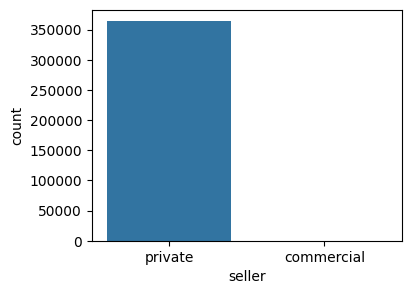

Distribucion de la columna offerType


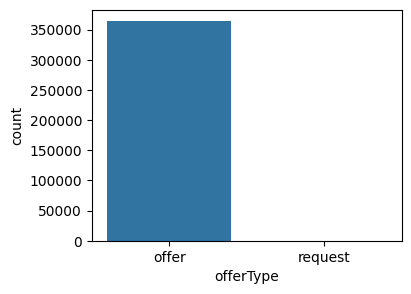

Distribucion de la columna vehicleType


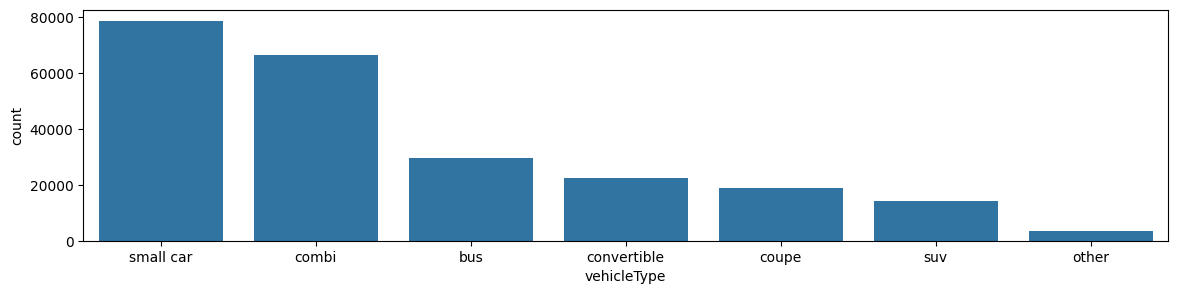

Distribucion de la columna gearbox


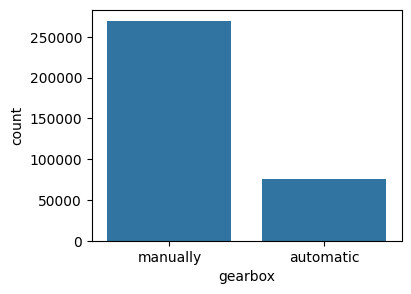

Columna model tiene demasiadas categorías: 251


Distribucion de la columna fuelType


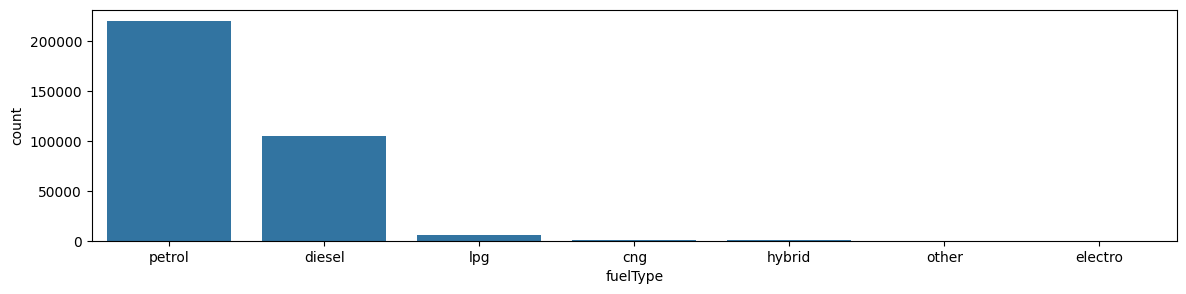

Distribucion de la columna brand


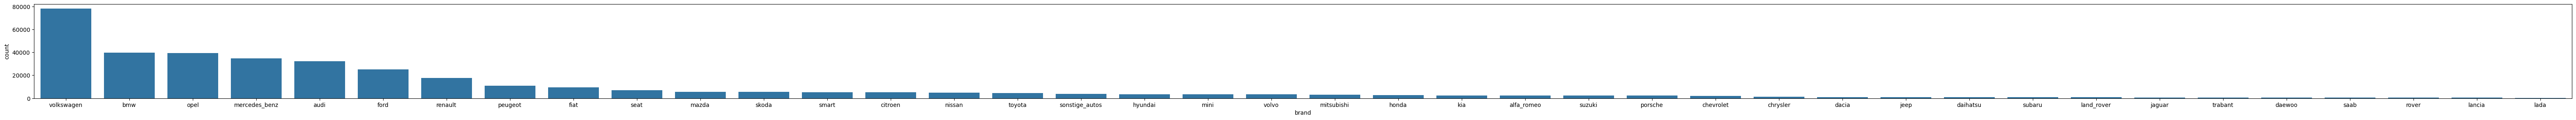

Distribucion de la columna notRepairedDamage


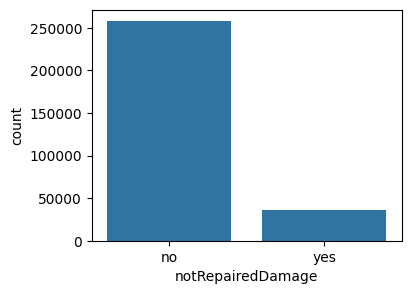

In [25]:
for col in columnas_cat:

    if df[col].nunique() > 200:
        print(f"Columna {col} tiene demasiadas categorías: {df[col].nunique()}\n\n")
        continue
    print(f"Distribucion de la columna {col}")
    plt.figure(figsize=(df[col].nunique()*2 ,3))
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.show()